In [1]:
from pymongo import MongoClient
from collections import OrderedDict

import numpy as np

import datashader as ds
import datashader.transfer_functions as tf
from bokeh.models import Range1d
from bokeh.plotting import Figure
from bokeh.io import output_notebook, show
from bokeh.tile_providers import STAMEN_TONER
from bokeh.resources import INLINE
output_notebook(resources=INLINE)


import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from datashader.bokeh_ext import InteractiveImage

import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [2]:
client = MongoClient('localhost')
print("Authentatied for spectral_profiler:", client.spectral_profiler.authenticate('owner', 'data'))
print("Authentatied for selene:", client.selene.authenticate('owner', 'data'))

Authentatied for spectral_profiler: True
Authentatied for selene: True


In [3]:
point_data = client.selene.points

wavelengths = [512.6, 518.4, 524.7, 530.4, 536.5, 542.8, 548.7, 554.5, 560.5, 566.7, 572.6, 578.5, 584.5, 590.6, 596.7, 602.5, 608.6, 614.6, 620.5, 626.7, 632.7, 638.6, 644.6, 650.6, 656.6, 662.6, 668.8, 674.7, 680.6, 686.7, 692.6, 698.6, 704.7, 710.8, 716.7, 722.7, 728.7, 734.7, 740.7, 746.8, 752.8, 758.7, 764.8, 770.7, 776.7, 782.7, 788.8, 794.7, 800.7, 806.8, 812.7, 818.7, 824.8, 830.8, 836.8, 842.8, 848.8, 854.6, 860.7, 866.7, 872.7, 878.7, 884.6, 890.7, 896.6, 902.7, 908.7, 914.6, 920.6, 926.6, 932.6, 938.6, 944.6, 950.6, 955.4, 963.5, 971.4, 979.7, 987.6, 993.7, 1013.1, 1019.5, 1027.7, 1035.5, 1043.6, 1051.7, 1059.7, 1067.8, 1075.8, 1083.6, 1091.8, 1099.7, 1107.7, 1115.9, 1123.8, 1131.8, 1139.7, 1147.8, 1155.7, 1163.8, 1171.8, 1179.8, 1187.8, 1195.8, 1203.9, 1211.9, 1219.8, 1227.9, 1235.9, 1244.0, 1252.0, 1259.8, 1267.8, 1275.9, 1284.2, 1292.0, 1299.8, 1307.8, 1315.9, 1323.8, 1331.8, 1339.8, 1347.8, 1355.8, 1363.8, 1371.8, 1379.8, 1387.8, 1395.9, 1403.8, 1411.8, 1419.8, 1427.9, 1435.7, 1443.8, 1451.9, 1459.8, 1467.8, 1475.8, 1483.9, 1491.8, 1499.8, 1507.8, 1515.7, 1523.8, 1531.7, 1539.7, 1547.7, 1555.5, 1563.7, 1571.7, 1579.6, 1587.7, 1595.7, 1603.7, 1611.7, 1620.1, 1628.1, 1636.1, 1644.2, 1717.6, 1725.6, 1733.7, 1742.0, 1749.7, 1757.7, 1766.3, 1773.6, 1782.2, 1789.8, 1797.6, 1805.8, 1813.7, 1822.0, 1830.0, 1837.6, 1845.6, 1853.7, 1861.8, 1870.1, 1877.3, 1885.7, 1893.7, 1901.5, 1910.0, 1918.0, 1925.3, 1934.3, 1948.8, 1957.6, 1965.9, 1973.3, 1981.3, 1989.4, 1997.7, 2005.8, 2013.0, 2021.5, 2029.3, 2037.4, 2045.8, 2053.3, 2061.3, 2069.4, 2077.0, 2085.5, 2093.0, 2101.9, 2109.2, 2117.0, 2125.4, 2132.9, 2141.5, 2149.0, 2156.8, 2165.2, 2172.8, 2181.0, 2189.4, 2196.8, 2204.7, 2213.0, 2221.2, 2228.7, 2236.8, 2245.0, 2252.5, 2260.7, 2269.2, 2276.6, 2284.7, 2292.7, 2300.4, 2308.9, 2316.4, 2324.0, 2332.6, 2340.6, 2348.3, 2356.2, 2364.6, 2372.2, 2380.2, 2388.5, 2396.2, 2404.2, 2412.2, 2420.2, 2428.0, 2436.3, 2444.3, 2451.9, 2460.1, 2467.9, 2476.0, 2484.1, 2492.6, 2500.1, 2508.1, 2516.1, 2524.1, 2532.1, 2540.0, 2548.0, 2556.0, 2564.0, 2572.0, 2579.9, 2587.9]
print('red', wavelengths[23])
print('green', wavelengths[0])
print('blue', wavelengths[0])

red 650.6
green 512.6
blue 512.6


In [36]:
%%time

# Find all points in circle with radius 100, I would reccomend reducing that number when running the notebook
points = client.selene.points.find().batch_size(300)
# points = client.selene.points.find({'loc': {'$geoWithin': { '$center': [[160.611921773, -73.7620361511], 20] }}})
size = points.count()
print(size)

1000011
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.4 ms


In [37]:
%%time
longitude_array = np.zeros((size,), dtype=np.float32)
latitude_array = np.zeros((size,), dtype=np.float32)

red_array = np.zeros((size,), dtype=np.float32)
blue_array = np.zeros((size,), dtype=np.float32)
green_array = np.zeros((size,), dtype=np.float32)

it = np.nditer([longitude_array, latitude_array, red_array, blue_array, green_array],flags=['f_index'], order='C', op_flags=['readwrite'])
while not it.finished:
    point = points.next()
    coords = point['loc']['coordinates']
    it[0] = coords[0]
    it[1] = coords[1]
    it[2] = point['ref2'][23]
    it[3] = point['ref2'][0]
    it[4] = .5  # Green is not captured by the SP
    it.iternext()


CPU times: user 1min 34s, sys: 2.54 s, total: 1min 36s
Wall time: 2min 12s


In [40]:
%%time
# data = np.asarray([longitude_array.reshape(size,1), latitude_array.reshape(size,1), red_array.reshape(size,1)])

data = np.append(longitude_array.reshape(size,1), latitude_array.reshape(size,1), 1)
data = np.append(data, np.clip(red_array.reshape(size,1), 0, 1), 1)
data = np.append(data, np.clip(blue_array.reshape(size,1), 0, 1), 1)
data = np.append(data, np.clip(green_array.reshape(size,1), 0, 1), 1)

# longitude_array.reshape(size,1)
# new = np.append(my_data, new_col, 1)

header = np.asarray(['long', 'lat', 'red', 'blue', 'green'])
dataframe = pd.DataFrame(data=data, columns=header)

color_array = dataframe.as_matrix(columns=['red', 'blue', 'green'])

CPU times: user 48 ms, sys: 48 ms, total: 96 ms
Wall time: 97.2 ms


In [41]:
%%time
dataframe[:10]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 421 µs


long        lat     red    blue  green
0  160.611923 -70.762039  0.0518  0.0286    0.5
1  160.610123 -70.743500  0.0524  0.0281    0.5
2  160.608337 -70.724968  0.0206  0.0120    0.5
3  160.606552 -70.706429  0.0048  0.0032    0.5
4  160.604752 -70.687897  0.0062  0.0028    0.5
5  160.602951 -70.669365  0.0115  0.0060    0.5
6  160.601166 -70.650841  0.0851  0.0477    0.5
7  160.599365 -70.632309  0.1704  0.0955    0.5
8  160.597580 -70.613777  0.1452  0.0824    0.5
9  159.076233 -27.696363  0.0570  0.0318    0.5

In [46]:
%%time

cmap = plt.get_cmap('bone')

canvas = ds.Canvas(plot_width=700, plot_height=500)
agg = canvas.points(dataframe, 'long', 'lat', ds.mean('blue'))
img = tf.shade(agg, cmap=cmap)
img = ds.transfer_functions.set_background(img, '#777777')

CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 206 ms


CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.06 ms


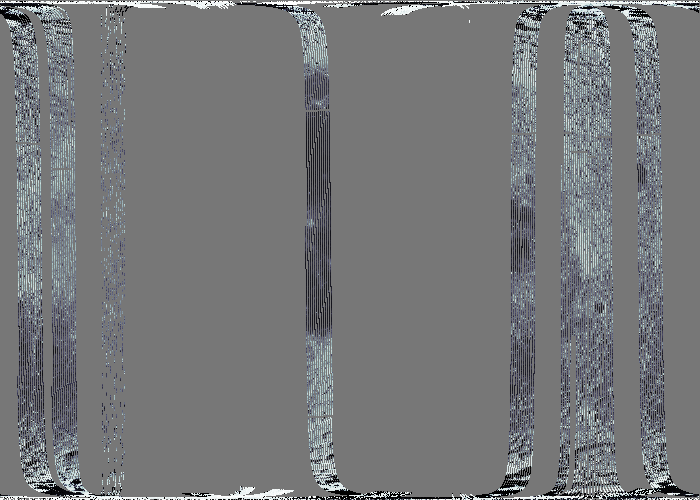

In [47]:
%%time
ds.transfer_functions.dynspread(img,max_px=10)

In [48]:
def base_plot(tools='pan,wheel_zoom,reset',plot_width=720, plot_height=400, x_range=None, y_range=None, **plot_args):
    p = Figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        background_fill_color='white',
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.add_tile(STAMEN_TONER)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

def update_image(x_range, y_range, w, h, how='log'):
    canvas = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = canvas.points(dataframe, 'long', 'lat', ds.mean('red'))
    img = tf.shade(agg, cmap=cmap)
    img = ds.transfer_functions.set_background(img, '#777777')
    return ds.transfer_functions.dynspread(img,  max_px=10)

p = base_plot(x_range=(-180, 180), y_range=(-90, 90))
InteractiveImage(p, update_image)

In [11]:
point = point_data.find_one()

In [12]:
from scipy.stats import percentileofscore

def plot_wavelength(refs, **kwargs):
    """
    Plot wavelength intesities. This can be reflectance, radience, raw, etc.
    """
    Colorize = plt.get_cmap('cool')
    
    plt.figure(figsize=(12,5))
    precentiles = [percentileofscore(refs, val)/100 for val in refs]
    plt.scatter(wavelengths, refs, color=Colorize(precentiles), s=20,label='Wavelength', marker='o',**kwargs)
    
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim([500,2580])
    plt.show()

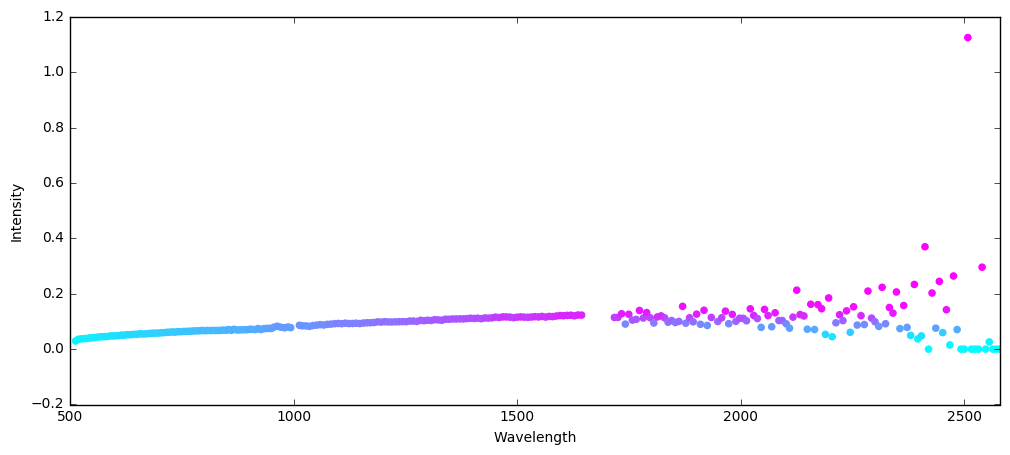

In [13]:
# Plot the first reflectance
plot_wavelength(point['ref1'])

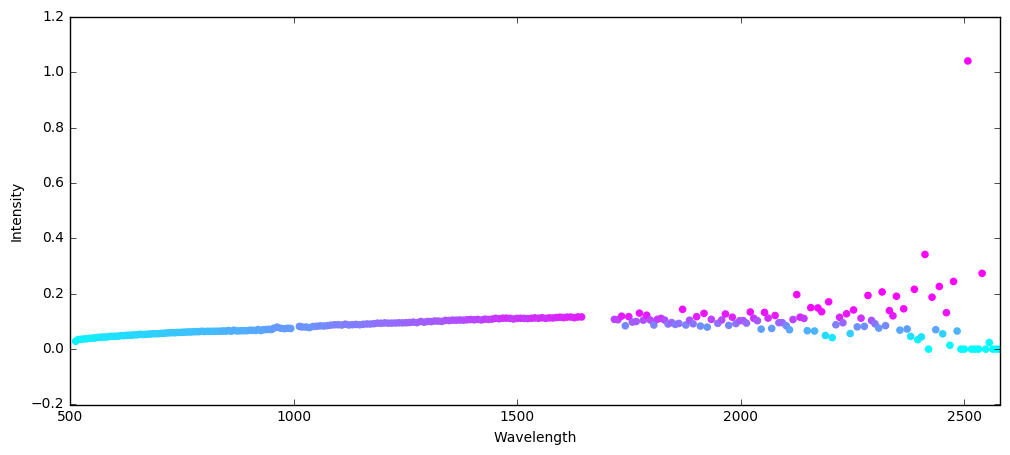

In [14]:
# Plot the secons reflectance
plot_wavelength(point['ref2'])

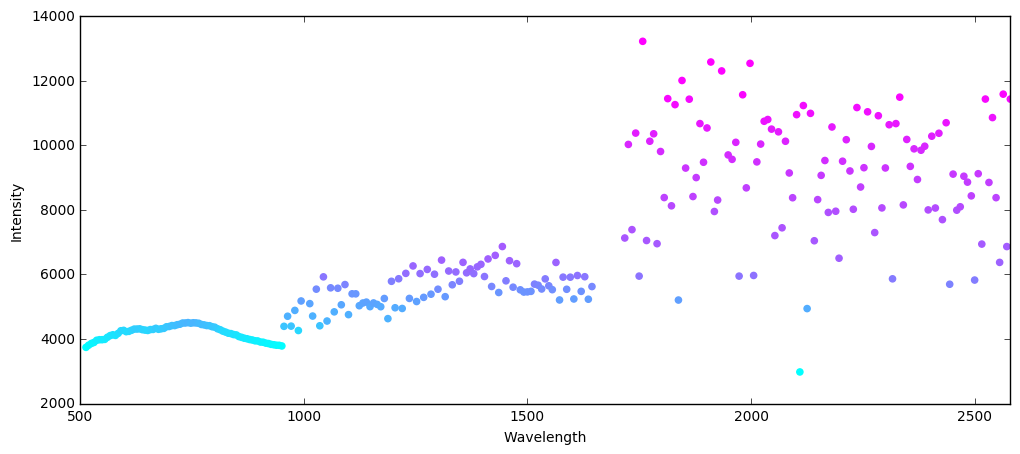

In [15]:
# Plot the RAW values
plot_wavelength(point['raw'])

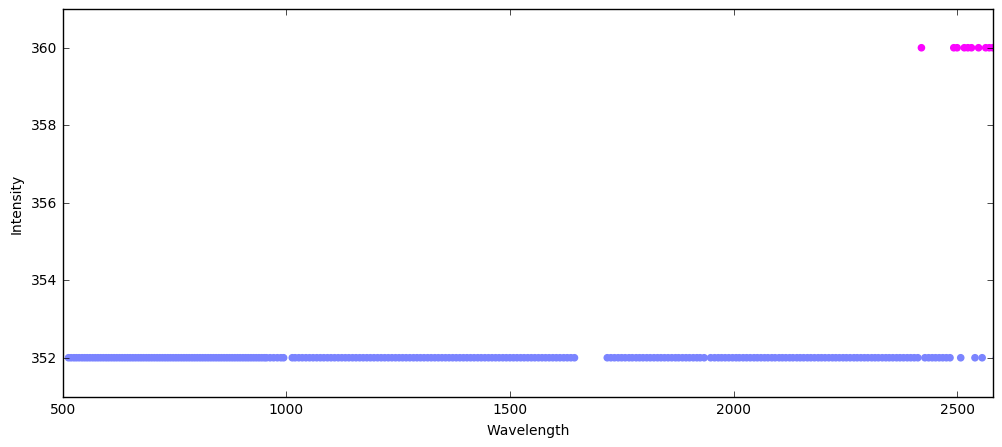

In [16]:
# get the quality vector
plot_wavelength(point['qa'])

In [17]:
# Get the meta data
point['meta']

{'CALIBRATION': 0.0,
 'CENTER_LATITUDE': -70.7620361511,
 'CENTER_LONGITUDE': 160.611921773,
 'CLOCK_COUNT_ERR_FLAG': 0.0,
 'DPU_TEMPERATURE': 12.3226003647,
 'EMISSION_ANGLE': 0.9519629478,
 'GEOMETRIC_INFO_RECAL_FLAG': 67.0,
 'HALOGEN_BULB_RADIANCE': 4.7589998245,
 'HALOGEN_BULB_TEMPERATURE1': 7.8099999428,
 'HALOGEN_BULB_TEMPERATURE2': 7.8099999428,
 'HALOGEN_BULB_VOLTAGE1': 4.7589998245,
 'HALOGEN_BULB_VOLTAGE2': 4.7589998245,
 'INCIDENCE_ANGLE': 80.4272918701,
 'NIR1_FOCAL_PLANE_TEMPERATURE': 16.4599990845,
 'NIR2_FOCAL_PLANE_TEMPERATURE': 243.0,
 'PHASE_ANGLE': 80.0595397949,
 'SOLAR_AZIMUTH_ANGLE': 299.1752624512,
 'SPACECRAFT_ALTITUDE': 100.4962005615,
 'SPACECRAFT_AZIMUTH': 6.3752999306,
 'SPACECRAFT_CLOCK_COUNT': 902206645.940682,
 'SPACECRAFT_GROUND_SPEED': 1.5443203449,
 'SPATIAL_RESOLUTION_FLAG': 65.0,
 'SPECTROMETER_TEMPERATURE_1': 16.7099990845,
 'SPECTROMETER_TEMPERATURE_2': 20.0,
 'SPECTROMETER_TEMPERATURE_3': 17.0499992371,
 'SPECTROMETER_TEMPERATURE_4': 22.4200000763

In [18]:
point['loc']

{'coordinates': [160.611921773, -70.7620361511], 'type': 'Point'}

In [19]:
print(point['raw'])

[3739.0, 3805.0, 3860.0, 3891.0, 3958.0, 3975.0, 3976.0, 3986.0, 4051.0, 4103.0, 4128.0, 4109.0, 4172.0, 4253.0, 4265.0, 4224.0, 4235.0, 4269.0, 4304.0, 4306.0, 4312.0, 4287.0, 4274.0, 4262.0, 4289.0, 4294.0, 4328.0, 4298.0, 4313.0, 4327.0, 4376.0, 4385.0, 4413.0, 4413.0, 4440.0, 4455.0, 4492.0, 4493.0, 4505.0, 4488.0, 4500.0, 4495.0, 4484.0, 4447.0, 4434.0, 4414.0, 4409.0, 4378.0, 4362.0, 4314.0, 4285.0, 4241.0, 4211.0, 4177.0, 4164.0, 4135.0, 4123.0, 4073.0, 4048.0, 4021.0, 4005.0, 3981.0, 3967.0, 3942.0, 3937.0, 3904.0, 3898.0, 3870.0, 3857.0, 3832.0, 3819.0, 3805.0, 3802.0, 3782.0, 4390.0, 4702.0, 4396.0, 4883.0, 4260.0, 5175.0, 5093.0, 4708.0, 5541.0, 4407.0, 5922.0, 4554.0, 5582.0, 4838.0, 5569.0, 5057.0, 5683.0, 4752.0, 5397.0, 5396.0, 5028.0, 5112.0, 5140.0, 4999.0, 5114.0, 5069.0, 4997.0, 5252.0, 4628.0, 5784.0, 4965.0, 5863.0, 4943.0, 6030.0, 5254.0, 6260.0, 5158.0, 6023.0, 5287.0, 6152.0, 5385.0, 6004.0, 5539.0, 6441.0, 5308.0, 6103.0, 5676.0, 6074.0, 5786.0, 6371.0, 6047.0,